In [1]:
# Python SQL toolkit and Object Relational Mapper
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.patches as mp
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, and_

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [3]:
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

In [4]:
prcp_each_day = session.query(func.strftime("%Y-%m-%d",Measurement.date), func.sum(Measurement.prcp))\
            .filter(Measurement.date.between('2016-08-01','2017-07-31')).group_by(Measurement.date)\
            .order_by(Measurement.date).all()
prcp_each_day[:10]

dates = [i[0] for i in prcp_each_day]
precipitation = [(i[1]) for i in prcp_each_day]
print(dates[:5],'\n', precipitation[:5])


len(dates)
len(precipitation)

['2016-08-01', '2016-08-02', '2016-08-03', '2016-08-04', '2016-08-05'] 
 [8.71, 2.84, 0.05, 1.81, 0.34]


365

In [5]:
precip_data = session.query(Measurement).first()
precip_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10e494b70>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [6]:
prcp_each_day_df = pd.DataFrame(prcp_each_day, columns=['dates', 'precipitation'])
prcp_each_day_df.set_index(['dates'], inplace=True)
prcp_each_day_df.head()

,precipitation
dates,
2016-08-01,8.71
2016-08-02,2.84
2016-08-03,0.05
2016-08-04,1.81
2016-08-05,0.34


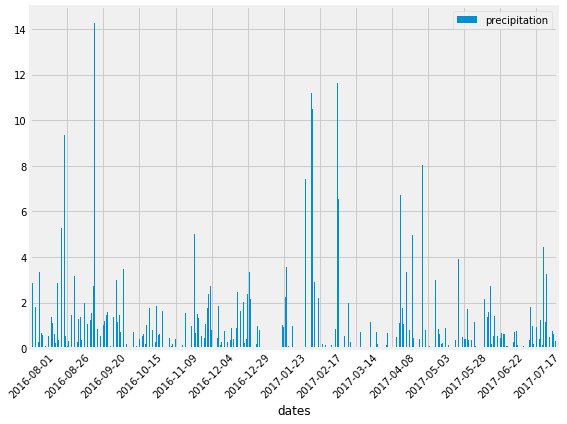

In [7]:
ax = prcp_each_day_df.plot(kind='bar', figsize=(8,6))
n = 25

xticks = ax.xaxis.get_ticklocs()
xticklabels = [tick.get_text() for tick in ax.xaxis.get_ticklabels()]
ax.set_xticks(xticks[::n])
ax.set_xticklabels(xticklabels[::n], rotation=45)
plt.tight_layout()                           
plt.show()

In [8]:
prcp_each_day_df.describe()

,precipitation
count,365.000000
mean,1.062137
std,1.840263
min,0.000000
25%,0.060000
50%,0.430000
75%,1.210000
max,14.280000


In [9]:
# Design a query to show how many stations are available in this dataset?
station_data = session.query(Station).first()
station_data.__dict__
num_stations = session.query(Station.station).count()
print("The number of stations is: %s" % num_stations)


The number of stations is: 9


In [10]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station ,func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
    
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [11]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = session.query(Measurement.tobs).\
                    filter(Measurement.station == active_stations[0][0]).\
                    filter(Measurement.date.between('2016-08-01','2017-07-31')).\
                    order_by(Measurement.tobs.desc()).all()
most_active[:10]
most_active_tobs = [float(i[0]) for i in most_active]
most_active_tobs[:5]

[82.0, 82.0, 82.0, 82.0, 81.0]

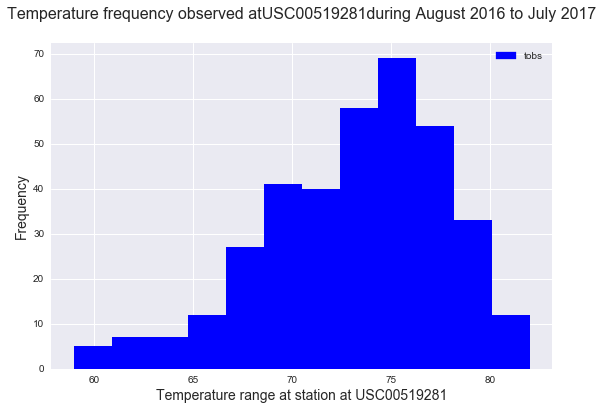

In [12]:

# # creating Histogram for most_active station tobs with bin size = 12
sns.set()
plt.figure(figsize=(8,6))
plt.hist(most_active_tobs, bins=12, color='blue')
plt.title('Temperature frequency observed at'+ active_stations[0][0] + 'during August 2016 to July 2017\n', fontsize = 16)
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('Temperature range at station at ' + active_stations[0][0], fontsize = 14)

proxy_tobs = mp.Patch(color='blue', label='tobs')
plt.legend(handles=[proxy_tobs])
plt.show()

In [13]:
def calc_temps(start_date, end_date):
    #create dates 1 year prior
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    #query database for temps from those dates
    temp_values = session.query(Measurement.tobs).filter(Measurement.date >= new_dates[0], Measurement.date <= new_dates[1]).all()
    temp_values_list = [x for (x,) in temp_values]
    avg_temp = np.mean(temp_values_list)
    max_temp = max(temp_values_list)
    min_temp = min(temp_values_list)
    
    # create bar graph
    plt.figure(figsize=(2,5))
    plt.title("Trip Average Temp")
    plt.ylabel("Temperature (F)")
    plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "")
    plt.show()

['2017-08-01', '2017-08-14']


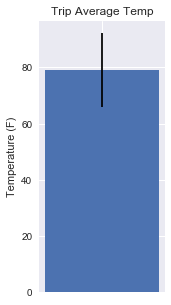

In [14]:
calc_temps('2018-08-01', '2018-08-14')